# Future price levels for electricity in Melbourne and battery storage to buy low, sell high

## Executive Summary
### Future prices
- The electricity prices in Melbourne varied by more than a factor of two in the 5.5 years of data analyzed here. While there are seasonal and weekly regularities in the price and demand of electricity, these **seasonal effects only account for a small fraction of the variation in electricity prices**. This is likely due to the price of electricity following the prices of fossil fuels, which are still used to generate the majority of the electricity in the world. The price of fossil fuels on the other hand is tied to things like geopolitics and the state of the global economy, which are much more difficult to predict than the changing of the seasons.
- I expect electricity prices to return to at least 2017-2019 levels as the world economy recovers from the COVID pandemic. Thus we can expect an **average price of 102 AUD/ MWh** for Melbourne once the COVID pandemic subsides.
- There are two sesonal peaks in demand and price for electricity in Melbourne:
    - The **mean demand for electricity is highest during the Australian winter**, presumably due to increased electricity use in heating (the average low in June/July in Melbourne is around 8 C / 46 F). This is also reflected in the prices: at roughly 20% higher than the yearly average, the mean electricity price shows a peak in June and July compared to the fall and spring months
    - The **highest peak demand occurs during the heat of summer**, when people crank up the air conditioning on days with highs of more than 40 degrees celcius. The electricity production in Melbourne doesn't always seem to be able to keep up with demand on these days, and prices skyrocket. This results in the prices in January being approximately 50% higher than the yearly average, and with **large daily variance in both demand and prices**. This is good news from the point of view of solar arrays, since their production will be at a maximum on sunny summer days.
- The expected mean prices for each month are shown in the plot below. The black lines on each bar are proportional to the variance in prices for each month.

![Expected prices for each mont](../saved_images/expected_prices.jpg)

- Demand and price also vary by day of week: on weekdays the demand and price are higher than during the weekend or on holidays. For demand, the difference is approximately 10%, for prices around 25%. The variation in prices is shown in the figure below.

![Price by day of the week](../saved_images/week_vs_weekend.jpg)

- For estimating the prices for the next 12-18 months, I recommend using the average price of 102 AUD/ MWh that was seen before the pandemic, and to scale that price by the monthly relative price. If one is interested in a particular day, whether or not the day is a weekend/holiday or a working day should be taken into account. 
- Since the seasonal effects explain only a small part of the price variation, to truly make accurate long term predictions we would need more data. The most important would probably be something that indicates long term pricing of fossil fuels, such as oil or gas futures.
- The return-on-investment for solar arrays Victoria seems very good: somewhere between 12-38% based on a quick estimate.

### Battery storage to buy low, sell high
- Battery storage is not financially viable at current electricity prices, battery costs and battery lifetimes:
    - 70 MWh lithium-ion battery would **cost 12 million AUD at a minimum**
    - With perfect information on tomorrow's electricity prices, the battery system could make a **profit of 300,000 AUD per year**, assuming we sell at mean daily prices.
    - **Yearly ROI is then 2.6%** - much more profitable to spend money on more solar panels rather than batteries
    - Battery system would take almost 40 years to pay back for itself. Lithium-ion batteries can last up to 3,500 charge-discharge cycles which would be just under 10 years if done daily. In our case the cycling might only occur every two days or so, but the batteries would still not be able to pay for themselves.
    - With minimal tuning, a **machine learning model (LightGBM, a gradient boosted tree regressor) can predict price differences between today's and tomorrow's prices well enough to make 48% of the maximum theoretical profit**. With some effort this can surely be improved, so that predicting when to store and when to sell electricity should not be a problem.
- Once the price of battery capacity comes down by a factor of four, it may start to become more profitable than solar panels
- Analysis of battery storage here assumed electricity is sold at mean daily price - profitability may be much improved if the electricity is sold during peak hours. I still would not expect this to be more than a factor of two increase in the yearly profit, making investing in solar arrays the better option for now.

## Import packages

In [88]:
%%capture
# Install LightGBM for predicting daily energy prices
!pip install lightgbm

from typing import Tuple

from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import sem
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

## Import and preprocess data

In [89]:
def load_data():
    df = pd.read_csv('./data/energy_demand.csv')
    column_mapper = {"RRP":"price", "demand_pos_RRP":"demand_pos_price", "RRP_positive":"price_positive", "demand_neg_RRP":"demand_neg_price", "RRP_negative":"price_negative", "frac_at_neg_RRP":"frac_neg_price"}
    df.rename(columns = column_mapper, inplace = True)

    # Convert datatypes
    df.date = pd.to_datetime(df.date)
    df.school_day = df.school_day.map({"N": False, "Y":True}).astype('bool')
    df.holiday = df.holiday.map({"N": False, "Y":True}).astype('bool')

    # Extract year, month and day of week from data
    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month
    df['dow'] = df.date.dt.day_of_week
    df['week'] = df.date.dt.isocalendar().week.astype('int')

    # Convert solar exposure from MJ/m^2 to MWh/m^2 (1 MJ = 1/(60*60) MWh)
    df.solar_exposure = df.solar_exposure/3600

    # Set date as index so can do resampling using pandas
    df.set_index('date', inplace=True)
    
    return df

df = load_data()

## Electricity prices in Melbourne Jan 1 2015 - Oct 6 2020
The plot below shows the weekly median RRP for electricity in Melbourne. The range of the price (max - min) is shown by the shaded blue area. Some things to note:
- The price of electricity increased significantly during the first quarter of 2017, and stayed at this level for the next 2.5 years. The increase in price coincides with the closure of the [Hazelwood coal power station](https://en.wikipedia.org/wiki/Hazelwood_Power_Station#Closure_and_decommissioning), shown by the dashed line in the figure. It seems likely that the higher price is due to switching from coal to natural gas which is cleaner but more expensive.
- The price of electricity started going down already before the COVID pandemic started (start of lockdown in Victoria is shown by the dot-dashed line in the figure), and is expected to stay low while economic activity is decreased due to the COVID lockdown. Once the pandemic subsides, the price is likely to go up again as oil, gas and coal producers struggle to keep up with demand, having decreased production during the pandemic.
- Seasonal variations in electricity prices are not easily discernible in the data. The seasons do have an effect as shown later, but it is masked by the effect of other factors (probably variation in the price of fossil fuels).
- There are a number of days in the Australian summer (mostly in January) where the price is 10s of times the median weekly price. This seems to indicate that on very hot days, electricity production in Melbourne is not able to keep up with the demand for air conditioning units working on overdrive. This is good nows from the point of view of solar cell arrays, since they will work very well during sunny summer days.

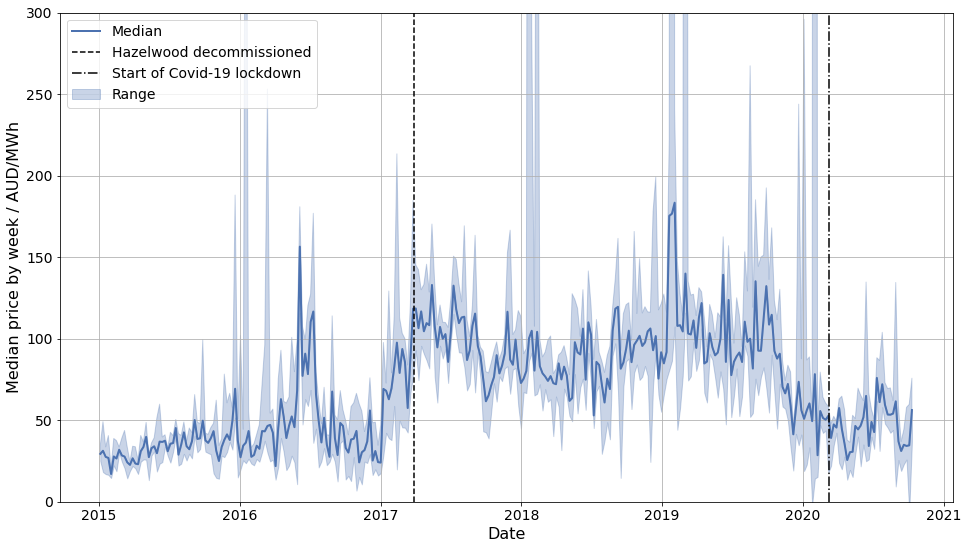

In [90]:
fig, ax = plt.subplots()
sample_window = '1W'
weekly_median = df.resample(sample_window).price.median()
weekly_max = df.resample(sample_window).price.max()
weekly_min = df.resample(sample_window).price.min()

ax.plot(weekly_median.index, weekly_median, lw = 2, label = 'Median')
ax.fill_between(weekly_median.index, weekly_max, weekly_median, alpha = 0.3, color = 'C0', label = 'Range')
ax.fill_between(weekly_median.index, weekly_min, weekly_median, alpha = 0.3,  color = 'C0')

ax.axvline(pd.Timestamp('2017-3-29'), ls = '--', c = 'k', label = 'Hazelwood decommissioned')
ax.axvline(pd.Timestamp('2020-3-10'), ls = '-.', c = 'k', label = 'Start of Covid-19 lockdown')

ax.set_ylabel('Median price by week / AUD/MWh')
ax.set_xlabel('Date')
ax.set_ylim([0, 300])
ax.legend()
ax.grid()

Get the average price in during 2017-2019:

In [91]:
print(f"Mean price during 2017, 2018 and 2019: {df['2017-01-01':'2019-12-31'].price.mean():.1f} AUD/MWh")

Mean price during 2017, 2018 and 2019: 102.2 AUD/MWh


## Seasonal variation in prices
- Though overshadowed by the effects of other variables, such as fossil fuel prices, the price of electricity does also show variations by season, and also by day of the week
- As shown below, these changes in price seem to be driven by variations in demand: higher demand results in higher prices as one might expect based on basic economics.
- Average demand is highest during the winter, but peak daily demand is reached during the summer.
- The peak prices and demand occur during the hottest days in the data so they are likely due to electricity demand from air conditioning outstripping supply.
- Solar arrays produce the most electricity during the summer when they get more sunexposure, so they would be able to supply electricity when it is at its most valuable during hot, sunny days.

### Variation in demand
The plot below shows the seasonal variation in demand for electricity. The average demand is highest during the Australian winter (peaking around June and July), presumbaly due to electrical heating. The highest peak demand, however, is during the summer on very hot days where the need for air conditioning causes a surge.

Text(0.5, 0, 'Month')

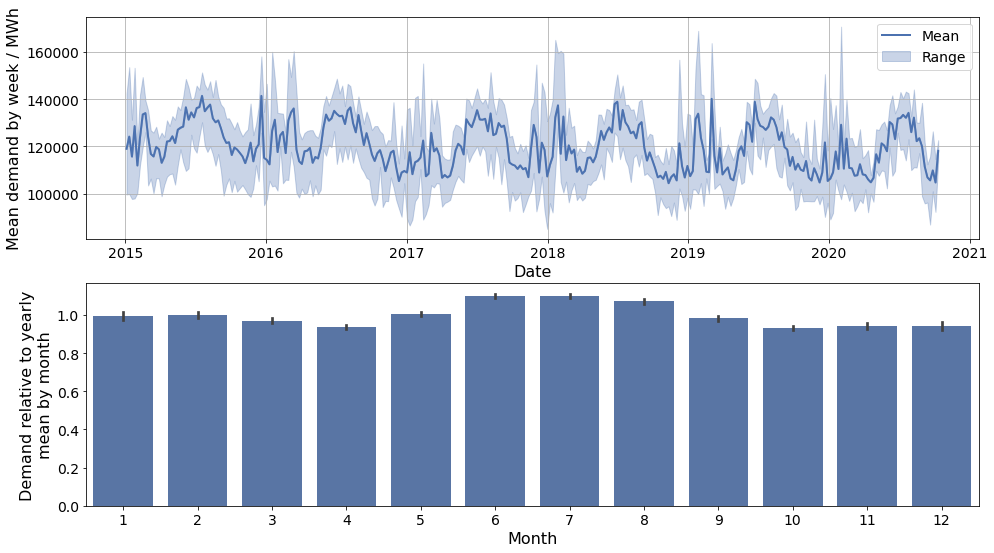

In [92]:
fig, (ax, ax_bar) = plt.subplots(2,1)
sample_window = '1W'
weekly_mean = df.resample(sample_window).demand.mean()
weekly_max = df.resample(sample_window).demand.max()
weekly_min = df.resample(sample_window).demand.min()

ax.plot(weekly_mean.index, weekly_mean, lw = 2, label = 'Mean')
ax.fill_between(weekly_mean.index, weekly_max, weekly_mean, alpha = 0.3, color = 'C0', label = 'Range')
ax.fill_between(weekly_mean.index, weekly_min, weekly_mean, alpha = 0.3,  color = 'C0')

ax.set_ylabel('Mean demand by week / MWh')
ax.set_xlabel('Date')
ax.legend()
ax.grid(True)


yearly_means = df.groupby('year').demand.mean().to_frame('mean_yearly_demand')
df_temp = df.copy()
df_temp = df_temp.merge(yearly_means, on = 'year')
df_temp['relative_demand'] = df_temp.demand/df_temp.mean_yearly_demand

ax = sns.barplot(data = df_temp, y = 'relative_demand', x = 'month', estimator = np.mean, color = 'C0')
ax.set_ylabel('Demand relative to yearly\nmean by month')
ax.set_xlabel('Month')

### Correlation between demand and price
The plot below shows the correlation between electricity price and demand. Higher demand results in a higher price, as one might expect based on basic economics. The demand explains roughly 25% of the variance in the prices. Since the correlation is fairly weak, the seasonal variations are difficult to see by eye when plotting the price over time, even though the demand has clear seasonal variation.

Correlation coefficient between demand and price: 0.259


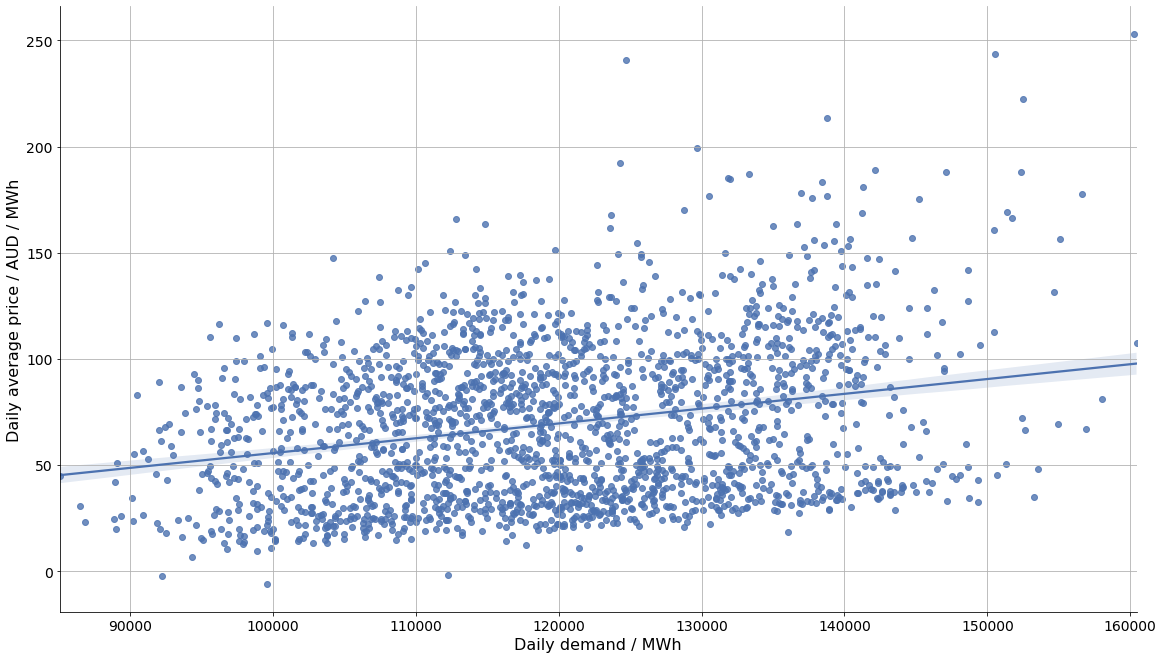

In [93]:
grid = sns.lmplot(data = df[df.price < df.price.median()*4], x = 'demand', y = 'price', height = 9, aspect = 16/9, )
grid.axes[0,0].set_xlabel('Daily demand / MWh')
grid.axes[0,0].set_ylabel('Daily average price / AUD / MWh')
grid.axes[0,0].grid(True)

df_no_outliers = df[df.price < 4*df.price.median()]
corr_coeff = df_no_outliers[['demand']].corrwith(df_no_outliers.price)
print(f"Correlation coefficient between demand and price: {corr_coeff[0]:.3f}")

### Seasonal variation in relative price
To better see the variation in price by season, we can plot the average monthly prices normalized by the average price for the year, as done in the barplot below. 

Observations:
- The mean price of electricity is the highest during January. As mentioned before, this is due to days of extreme heat, during which the demand for electricity (probably due to air conditioning) outstrips supply causing prices to surge.
- During the coldest part of the year (June-July), the mean price is also slightly higher than the rest of the year. This is likely due to heating increasing demand for electricity.

Text(0.5, 0, 'Month')

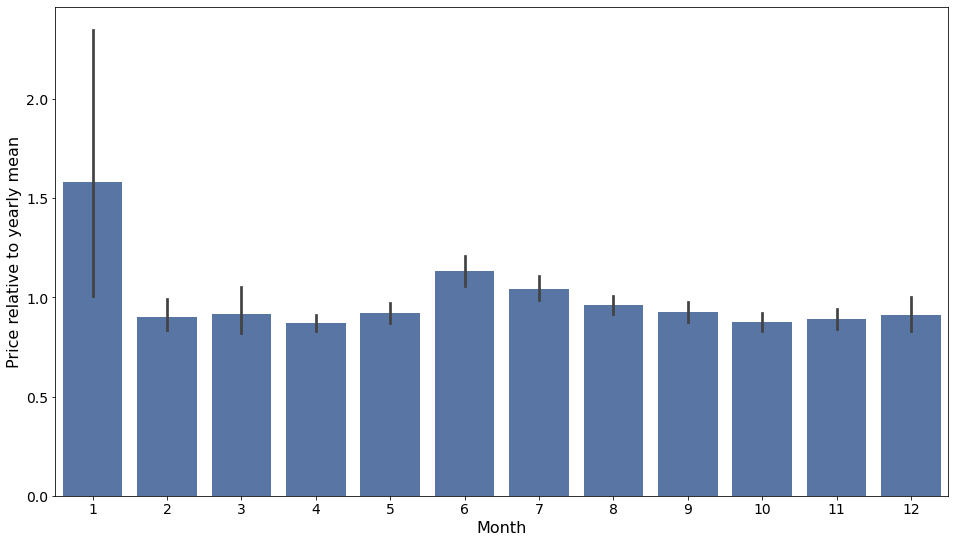

In [94]:
yearly_medians = df.groupby('year').price.mean().to_frame('mean_yearly_price')
df_temp = df.copy()
df_temp = df_temp.merge(yearly_medians, on = 'year')
df_temp['relative_price'] = df_temp.price/df_temp.mean_yearly_price
df_temp['expected_price'] = df_temp.relative_price*102

ax = sns.barplot(data = df_temp, y = 'relative_price', x = 'month', estimator = np.mean, color = 'C0')
ax.set_ylabel('Price relative to yearly mean')
ax.set_xlabel('Month')

# ax = sns.barplot(data = df_temp, y = 'expected_price', x = 'month', estimator = np.mean, color = 'C0')
# ax.set_ylabel('Expected mean electricity price by month\n/ AUD')
# ax.set_xlabel('Month')

# plt.savefig('./figures/expected_prices.jpg')

Finally, it is useful to know when we might expect demand to outstrip supply, so that that we can make sure to have our batteries charged and solar arrays operational on those days.

The scatterplot below shows the price of energy against the daily maximum temperature. It seems that if the day's maximum temperature exceeds 37 degrees C, there is a possibility of electricity prices surging.

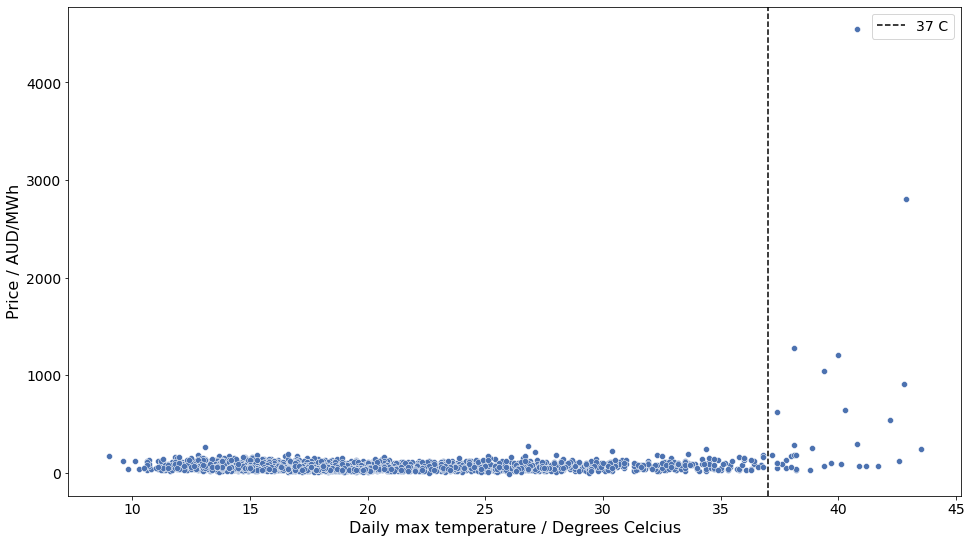

In [95]:
ax = sns.scatterplot(data = df, x = 'max_temperature', y = 'price')
ax.set_ylabel('Price / AUD/MWh')
ax.set_xlabel('Daily max temperature / Degrees Celcius')
ax.axvline(37, ls = '--', c = 'k', label = r'37 C')
ax.legend()

### Seasonal variation in prices and the value of electricity produced by solar arrays
The solar exposure varies greatly during the year in Melbourne, as shown by the plot below. There are also days during the summer when the solar exposure is low, presumably due to cloud cover.

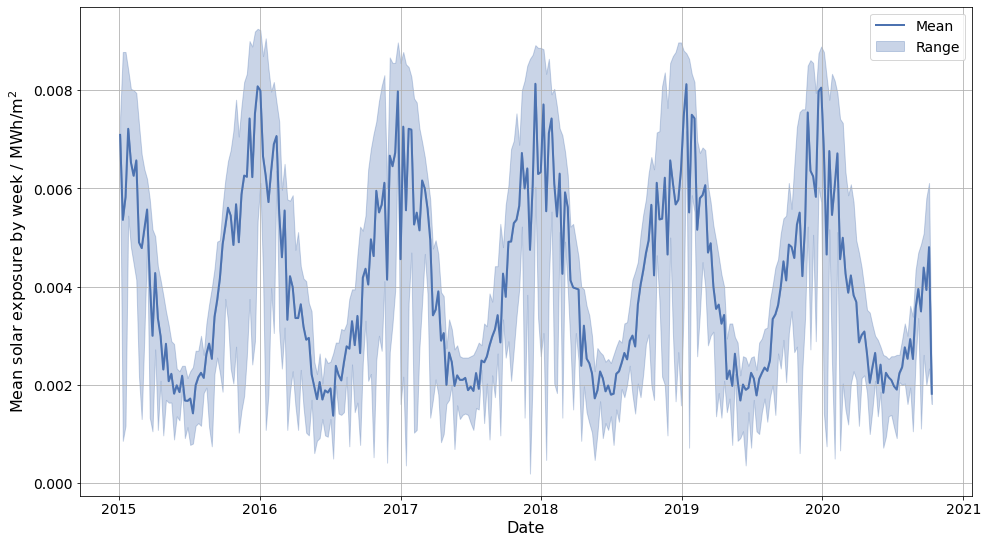

In [96]:
fig, ax = plt.subplots()
sample_window = '1W'
weekly_mean = df.resample(sample_window).solar_exposure.mean()
weekly_max = df.resample(sample_window).solar_exposure.max()
weekly_min = df.resample(sample_window).solar_exposure.min()

ax.plot(weekly_mean.index, weekly_mean, lw = 2, label = 'Mean')
ax.fill_between(weekly_median.index, weekly_max, weekly_mean, alpha = 0.3, color = 'C0', label = 'Range')
ax.fill_between(weekly_median.index, weekly_min, weekly_mean, alpha = 0.3,  color = 'C0')

ax.set_ylabel(r'Mean solar exposure by week / MWh/m$^2$')
ax.set_xlabel('Date')
ax.legend()
ax.grid(True)

Now let's calculate the average value of the electricity produced by a solar array, making the following assumptions:
- Using the prices for 2017-2019 (inclusive)
- Solar array is functional 100% of the time
- All of the electricity is sold at the average daily price (solar power peaks at midday while prices may not so this assumption is probably not true)

The average value of the electricity produced by a solar array is slightly more than the yearly average price since it is mostly produced in the summer where we have peaks in demand: 108.9 AUD/MWh vs 102.2 AUD/MWh.

In [97]:
df_1719 = df['2017-01-01':'2019-12-31']

weighted_average_price = (df_1719.solar_exposure * df_1719.price).sum()/df_1719.solar_exposure.sum()

print(f"Weighted average value of electricity produced by solar array: {weighted_average_price:.1f} AUD/MWh")

Weighted average value of electricity produced by solar array: 108.9 AUD/MWh


### Variations during the week: weekdays vs weekend
The demand and price show a clear trend during the week: from Monday to Friday the electricity demand is approximately 10% higher than during the weekend, and the price is correspondingly approximately 15% higher during the working week.

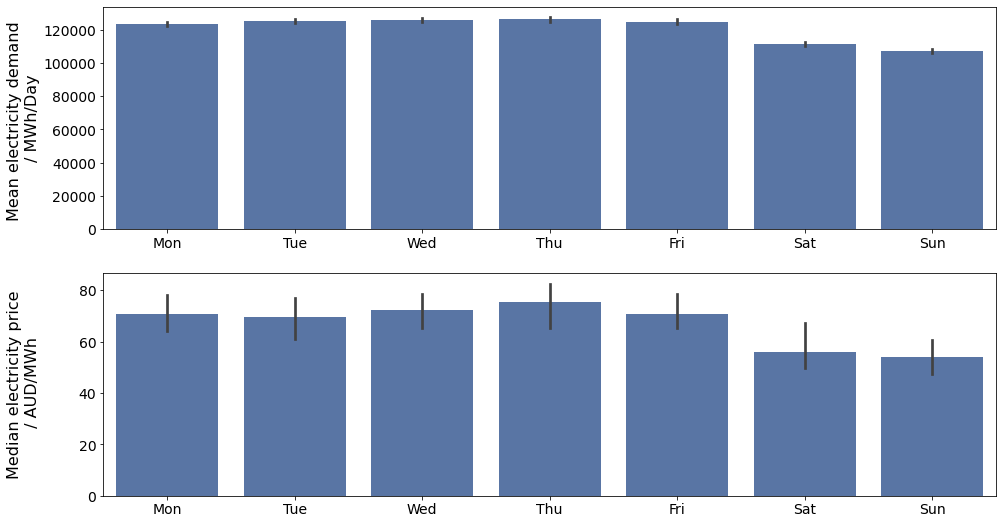

In [98]:
fig, (ax, ax2) = plt.subplots(2,1)

ax = sns.barplot(data = df[~df.holiday], x = 'dow', y = 'demand', color = 'C0', ax = ax)
ax.set_xlabel('')
ax.set_ylabel('Mean electricity demand \n/ MWh/Day')
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

ax2 = sns.barplot(data = df[~df.holiday], x = 'dow', y = 'price', estimator=np.median, color = 'C0', ax = ax2)
ax2.set_xlabel('')
ax2.set_ylabel('Median electricity price\n / AUD/MWh')
ax2.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
fig.align_ylabels([ax, ax2])

In [99]:
# Figure for summary
# df_temp = df.copy()
# df_temp['predicted_price'] = df_temp.price/df_temp.price.mean()*102
# df_temp['isweekday'] = ~df_temp.dow.isin([0,1,2,3,4])
# ax = sns.barplot(data = df_temp[~df_temp.holiday], x = 'isweekday', y = 'predicted_price', estimator=np.mean, color = 'C0')
# ax.set_xlabel('')
# ax.set_ylabel('Mean electricity price\n / AUD/MWh')
# ax.set_xticklabels(['Weekday', 'Weekend'])

# plt.savefig('./figures/week_vs_weekend.jpg')

### Variations year-to-year
The plot below shows the mean daily electricity demand for each complete year in the data. The demand seems to be decreasing slowly over the years, athough the effect is very small. This may be due to the jump in prices in 2016, or perhaps increased efficiency as Australia tries to combat climate change.

Text(0.5, 0, 'Year')

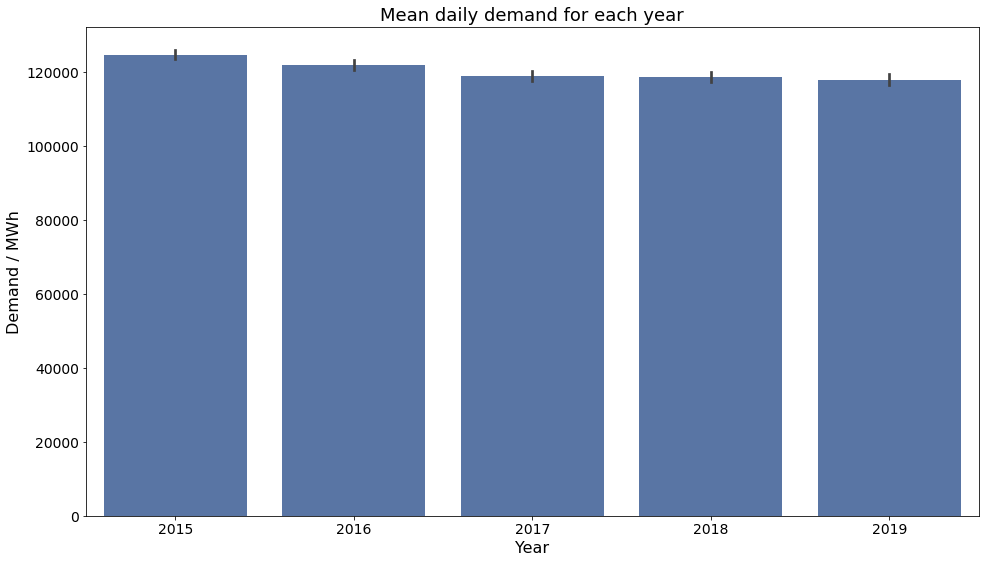

In [100]:
ax = sns.barplot(data = df[df.year != 2020], y = 'demand', x = 'year', estimator = np.mean, color = 'C0')
ax.set_title('Mean daily demand for each year')
ax.set_ylabel('Demand / MWh')
ax.set_xlabel('Year')

## Return on investment for solar panels
Given that a solar array produces electricity valued at 108.9 AUD/MWh on average, is it actually worth building solar arrays? And how long would it take for a solar array to pay back for itself?

Let's start by calculating the value of the electricity per unit area generated by the solar array over a year:

In [101]:
avg_price = 108.9
PV_efficiency = 0.2
electricity_values = df[df.year != 2020].groupby('year').solar_exposure.sum()*PV_efficiency*avg_price
mean_profit, error_in_mean = electricity_values.mean(), electricity_values.sem()

print(f"Assuming projected average price of {avg_price:.1f} AUD/MWh and solar cell efficiency of {PV_efficiency*100:.1f}%"
      f", mean yearly profit for 2015-2019 is {mean_profit:.1f} +/- {error_in_mean:.1f} AUD/m^2")

Assuming projected average price of 108.9 AUD/MWh and solar cell efficiency of 20.0%, mean yearly profit for 2015-2019 is 33.3 +/- 0.2 AUD/m^2


I can buy a 0.715 m x 0.810 m panel from [HomeDepot](https://images.thdstatic.com/catalog/pdfImages/d3/d30b0bf3-e332-4ba8-852f-80aedabf1c70.pdf) for around $100. Presumably you get a discount if you're buying in bulk so let's say you get a generous 50% discount. The price per square meter is then

In [102]:
discount = 0.5
price = 100
length = 0.810
width = 0.715
panel_cost = (1-discount)*price/(length*width)
print(f"Solar panel cost estimate: {panel_cost:.1f} AUD/m^2")


Solar panel cost estimate: 86.3 AUD/m^2


and the ROI is

In [103]:
print(f"Yearly ROI: {mean_profit/panel_cost*100:.1f} %")

Yearly ROI: 38.6 %


Based on this, a solar array in Melbourne is a great investment. The ROI above does not take into account installation and maintenance costs, or the degradation of the solar panels over time. With these factors included, the costs may go up significantly, and the efficiency of the panels will also lower over time, resulting in smaller profits. However, taking the lifetime of a solar panel to be [25-30 years](https://news.energysage.com/how-long-do-solar-panels-last/), they will have ample time to pay back for themselves (around 10 years, even if we triple the cost per square meter assumed here). 

## Sell high, buy low using battery storage
Exploring the prospect of using battery storage to store some of the energy produced when prices are low to then sell it for a higher price later.

To keep things simple, I'm making a few simplifying assumptions:
- If predicted price for tomorrow is higher than for today, I'm fully filling up the batteries (if the solar arrays aren't producing, just get electricity from the grid).
- Ignore costs due to battery cycling. Batteries can undergo a finite number of charge-discharge cycles, after which they need to be replaced, but I'm ignoring any costs due to this (and these costs are likely to be high)

### Cost for a 70 MWh battery
The cost per unit capacity for lithium ion batteries is something like 120-350 USD/kWh = 170-490 AUD/kWh ([National Renewable Energy Laboratory](https://www.nrel.gov/docs/fy21osti/79236.pdf), estimate for [Tesla](https://www.forbes.com/sites/greatspeculations/2021/12/01/are-battery-cost-improvements-still-a-big-driver-of-teslas-margins/?sh=447fbdcb4ae7), [Wikipedia](https://en.wikipedia.org/wiki/Sodium-ion_battery#Advantages_and_disadvantages_over_other_battery_technologies)), so a 70 MWh battery would cost around 12 - 34 million AUD.

In [104]:
battery_price_per_kWh = 170
battery_price = 70000*battery_price_per_kWh/1e6
print(f"Cost for 70 MWh battery at {battery_price_per_kWh:.1f} AUD/kWh is {battery_price:.2f} million AUD")

Cost for 70 MWh battery at 170.0 AUD/kWh is 11.90 million AUD


### How well is it possible to do in theory?
If we were able to predict the future perfectly, how much money could we make using a 70 MWh battery system? The strategy would be to fill up the batteries whenever today's price is lower than tomorrow's.

Calculate the profit that would be made everyday:

In [105]:
df['price_tomorrow'] = df.price.shift(-1,'D')
df['fill_battery'] = df.price_tomorrow > df.price
df['profit'] = (df.price_tomorrow - df.price)*df.fill_battery*70

Total profit over the entire time period is then roughly \\$1.8M, which corresponds to a daily profit of roughly 860 AUD (314,000 AUD yearly)

In [106]:
total_profit = df.profit.sum()/1e6
print(f"Total maximum profit over time period in data: {total_profit:.2f} million AUD")

daily_profit = df.profit.mean()
print(f"Mean daily profit over time period in data: {daily_profit:.0f} AUD ({daily_profit*365/1e3:.1f}k AUD yearly)")

annual_ROI = daily_profit*365/(battery_price*1e6)
print(f"Maximal yearly ROI for battery: {annual_ROI*100:.1f}%")

Total maximum profit over time period in data: 1.81 million AUD
Mean daily profit over time period in data: 861 AUD (314.3k AUD yearly)
Maximal yearly ROI for battery: 2.6%


The **maximum yearly return on investment is thus approximately 2.6%**, which is very low compared to typical returns for stocks and comparable to government bonds, with the caveat that the calculation here isn't taking into account account the depreciation of the batteries (which would further reduce the ROI). It would take the batteries roughly **40 years to pay back for themselves**, and it seems unlikely they would remain functional for that long (at least based on my personal experience with cell phone batteries...)

### To charge or not to charge: using LGBM to predict tomorrow's electricity price
In practice we don't have perfect information about tomorrow's electricity prices, so we are probably not able to reach the theoretical maximum profit for the battery system. It may be possible to predict whether or not tomorrow's price is higher than today's using achine learning, and make the decision to fill or not to fill the batteries based on a predictive model. In this section, I'm going to train a a gradient boosted tree ([LightGBMRegressor](https://lightgbm.readthedocs.io/en/latest/)) regression model to predict the price of electricity on a given day, provided the following information:
- Price of electricity for the past 7 days. We would probably have access to this data by the time we have to decide if we want to charge the batteries for tomorrow (current days prices might not be available in practice, but I'll assume they are for now).
- Weather info: min and max temperature, rainfall and solar exposure for the day. Weather forecasts are typically quite accurate for the next day, so we would have access to good approximations of this information.
- Historic electricity demand for the given day
- What day of the week is the day we are trying to predict, and is it a holiday

The code below generates the training data, fits the model, makes predictions and calculates some metrics of how well the predictions succeeded. This is done for 5 folds of data: for each fold the training data contains the full data - n\*100 days removed from the end of the data. The 100 days after the end of the training data is then used as the validation set for each fold.

#### Generate data
Generating the data needed for training a model

In [107]:
def generate_model_data(df: pd.DataFrame, N_prev = 7, N_folds = 5) -> pd.DataFrame:
    """
    Generates data that is used to train a model to predict electricity prices on a given day.
    """
    columns = ['demand',
               'price',
               'min_temperature',
               'max_temperature',
               'solar_exposure',
               'rainfall',
               'school_day',
               'holiday',
               'week']
    df = df.copy()[columns]
    
    # Get prices for N_prev days and store them as new columns
    for n in range(1,N_prev+1):
        df[f'price_{n}'] = df.price.shift(n,'D')
    
    df.attrs['N_prev'] = N_prev
        
    # Remove dates where previous prices are not available
    df.dropna(inplace = True)
    
    # Split data into folds for use in cross validation
    date_max = df.index.max()
    day = pd.Timedelta(1,'D')
    df['fold'] = 0
    for i, n in enumerate(range(N_folds,0,-1)):
        df.loc[date_max-(i+1)*100*day:date_max-i*100*day, 'fold'] = n
        
    df.reset_index(inplace = True)
        
    return df

def generate_train_test(df: pd.DataFrame, fold: int) -> Tuple[pd.DataFrame]:
    """
    Generates train and test datasets for a given test fold
    """
    df = df.copy()
    
    train = df[df.fold < fold]
    y_train = train.pop('price')
    X_train = train.drop(columns = ['demand','fold'])
    
    test = df[df.fold == fold]
    y_test = test.pop('price')
    X_test = test.drop(columns = ['demand', 'fold'])

    return X_train, y_train, X_test, y_test

def get_X_y(df: pd.DataFrame) -> Tuple[pd.DataFrame]:
    """
    Separates dataframe to features and target.
    """
    
    y = df.pop('price')
    X = df.drop(columns = ['demand', 'fold'])
    
    return X, y

#### Transform data
Define a pipeline for transforming data

In [108]:
def transform_data(df: pd.DataFrame, fold: int) -> pd.DataFrame:
    """
    Transforms the input data to be fit by the predictive model
    """
    
    df = calc_weekly_median(df)
    df = calc_historical_price(df, fold)    
    df = calc_historical_demand(df, fold)
    
    df.set_index('date', inplace = True)

    return df
    
def calc_weekly_median(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the median price of electricity for the past 7 days for each date in data.
    """
    cols = []
    for n in range(1,df.attrs['N_prev']+1):
        cols.append(f'price_{n}')
        
    df['median_price'] = df[cols].median(axis = 1)
    
    return df
    
def calc_historical_price(df: pd.DataFrame, fold: int) -> pd.DataFrame:
    """
    Calculates median historical price by week for each date using only data that is before the validation period (but not using data from future).
    """
    df = df.merge(df[df.fold < fold].groupby('week').price.median().to_frame('historical_median').reset_index(), on = 'week')
    return df

def calc_historical_demand(df: pd.DataFrame, fold: int) -> pd.DataFrame:
    """
    Calculates median historical demand by week for each date in data (but not using data from future).
    """
    df = df.merge(df[df.fold < fold].groupby('week').demand.median().to_frame('historical_demand').reset_index(), on = 'week')
    return df

#### Set up model

In [109]:
def fit_predict_LGBM(X_train: pd.DataFrame, y_train: pd.DataFrame, X_test: pd.DataFrame, params: dict = {}) -> pd.DataFrame:
    """
    Sets up a linear regression model, fits it to data and makes predictions.
    """
    model = LGBMRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    preds = X_test.copy()
    preds['predicted_price'] = y_pred
    preds['predicted_buy'] = (preds.predicted_price - preds.price_1) > 0

    return preds

#### Metrics

In [110]:
def correct_buy_percentage(y_true, y_pred) -> float:
    """
    Calculates the percentage of days where the model was able to corectly predict
    if the battery should be filled or not.
    """
    return np.mean(y_true==y_pred)

def percentage_of_max_profit(df) -> float:
    """
    Calculates the percentage of the max profit that was obtained.
    """
    return df.profit.sum()/df.max_profit.sum()

#### Cross validation

In [111]:
def cross_validate_LGBM(N_folds: int = 5, params: dict = {}):
    """
    Repeats the data generation, training, and testing of the model for
    different folds.
    """
    df = load_data()
    data_all_folds = generate_model_data(df)
    
    result_dict = {}
    result_dict['mape'] = []
    result_dict['cbp'] = []
    result_dict['pomp'] = []
    
    # Loop over the folds
    for fold in range(1, N_folds+1):
        data = transform_data(data_all_folds, fold)
        X_train, y_train, X_test, y_test = generate_train_test(data, fold)
        preds = fit_predict_LGBM(X_train, y_train, X_test, params=params)
        
        # Calculate data needed for calculating metrics
        preds['true_price'] = y_test
        preds['true_buy'] = (preds.true_price - preds.price_1) > 0
        preds['profit'] = (preds.true_price - preds.price_1)*preds.predicted_buy*70
        preds['max_profit'] = (preds.true_price - preds.price_1)*preds.true_buy*70
        
        # Calculate metrics
        mape = mean_absolute_percentage_error(preds.true_price, preds.predicted_price)
        cbp = correct_buy_percentage(preds.true_buy, preds.predicted_buy)
        pomp = percentage_of_max_profit(preds)
        
        result_dict['mape'].append(mape)
        result_dict['cbp'].append(cbp)
        result_dict['pomp'].append(pomp)
    
    return result_dict

def show_summary_stats(results_dict: dict):
    """
    Print the the mean and error in mean accross different folds
    """
    for metric, values in results_dict.items():
        mean = np.mean(values)
        std_err = sem(values)
        print(f"Mean for {metric}: {mean:.3f}+/-{std_err:.3f}")

#### Test the model
The metrics that are printed are:
- 'mape': mean absolute percentage error, smaller is better
- 'cbp': correct buy percentage - the percentage of times when the prediction of the model results in correctly charging or not charging the batteries. Larger is better
- 'pomp': percentage of maximum profits - the percentage of the maximum profit that the model achieved (max profit would be made if the prices for tomorrow were fully known

The percentage of maximum profits is the most important one of these, since profits are ultimately what determines if the battery system is a good investment or not, and this is what the model should ultimately be optimized for.

In [112]:
params = {"num_iterations": 200, "learning_rate": 0.05, "num_leaves": 8}
results = cross_validate_LGBM(params = params)
show_summary_stats(results)

Mean for mape: 0.390+/-0.089
Mean for cbp: 0.645+/-0.005
Mean for pomp: 0.485+/-0.033


The model could probably be improved quite significantly by tuning the hyperparameters and adding new features, but I think the result here demonstrates that we can reach profits that are within some tens of percent from the maximum profits. Predicting when to sell or store electricity does not seem too difficult, assuming we have accurate information about the prices for the past week, and the weather for the day we are trying to predict.